In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import random

import pydot
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.style.use('seaborn-white')

C:\Users\jkom8\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
def show_grid_search(model, X_train, y_train, tuned_parameters, scores):
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
            model, tuned_parameters, cv=3,
            scoring='%s_macro' % score, n_jobs=-1
        )
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
#        print("Grid scores on development set:")
#        print()
#        means = clf.cv_results_['mean_test_score']
#        stds = clf.cv_results_['std_test_score']
#        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#            print("%0.3f (+/-%0.03f) for %r"
#                  % (mean, std * 2, params))
#        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

# function for printing the ROC curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [3]:
# Load data
df = pd.read_csv("nhl_game_data/game_teams_stats.csv")
# normalize 
df['shots'] = (df['shots'] - df['shots'].mean()) / (df['shots'].max() - df['shots'].min())
df['goals'] = (df['goals'] - df['goals'].mean()) / (df['goals'].max() - df['goals'].min())
df['pim'] = (df['pim'] - df['pim'].mean()) / (df['pim'].max() - df['pim'].min())
df['powerPlayGoals'] = (df['powerPlayGoals'] - df['powerPlayGoals'].mean()) / (df['powerPlayGoals'].max() - df['powerPlayGoals'].min())
df['giveaways'] = (df['giveaways'] - df['giveaways'].mean()) / (df['giveaways'].max() - df['giveaways'].min())
df['takeaways'] = (df['takeaways'] - df['takeaways'].mean()) / (df['takeaways'].max() - df['takeaways'].min())
df['faceOffWinPercentage'] = (df['faceOffWinPercentage'] - df['faceOffWinPercentage'].mean()) / (df['faceOffWinPercentage'].max() - df['faceOffWinPercentage'].min())

# Change catergorical data to numerical
#df['won_true'] = df['won'].astype(int)
df['won_true'] = df['won'].map({True: 1, False:-1})
df.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,won_true
0,2011030221,1,away,False,OT,Peter DeBoer,0.025695,-0.081415,31,0.009968,3,0.067941,-0.087329,-0.073560,0.002587,-1
1,2011030221,4,home,True,OT,Peter Laviolette,0.125695,0.103770,27,-0.022819,6,0.067941,0.087329,0.120885,-0.094187,1
2,2011030222,1,away,True,REG,Peter DeBoer,0.125695,0.085252,32,0.009968,4,-0.098726,0.015411,-0.018004,0.002587,1
3,2011030222,4,home,False,REG,Peter Laviolette,-0.174305,-0.192526,24,0.119258,5,-0.098726,-0.015411,0.009773,-0.029671,-1
4,2011030223,4,away,False,OT,Peter Laviolette,0.025695,-0.044378,28,-0.033747,5,0.067941,0.013699,-0.184671,-0.190961,-1


In [4]:
# Features
X = df[['goals', 'shots', 'pim', 'powerPlayGoals', 'giveaways', 'takeaways', 'faceOffWinPercentage']]
# Target Variable
y = df['won_true']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [6]:
svc = SVC()
lr = LogisticRegression()

Optimized parameters for SVC and LR to be done with same training set for accurate comparison.

In [7]:
tuned_parameters = [{'solver':['liblinear'],
                     'C': [10, 100, 150, 200, 300],
                    'penalty':('l1', 'l2'),
                    'multi_class':('auto', 'ovr')},
                   {'solver':('newton-cg', 'lbfgs', 'sag',),
                     'C': [10, 100, 150, 200, 300],
                    'penalty':['l2'],
                    'multi_class':('auto', 'ovr', 'multinomial')},
                   {'solver':['saga'],
                     'C': [10, 100, 150, 200, 300],
                    'penalty':('l1', 'l2'),
                    'multi_class':('auto', 'ovr', 'multinomial')}]

scores = ['precision', 'recall']

show_grid_search(lr, X_train, y_train, tuned_parameters, scores)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 100, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

          -1       0.78      0.77      0.78      3413
           1       0.78      0.78      0.78      3448

    accuracy                           0.78      6861
   macro avg       0.78      0.78      0.78      6861
weighted avg       0.78      0.78      0.78      6861


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 100, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

          -1       0.7

In [9]:
#Best params are equal for precision and recall: 
#{'C': 100, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}
lr_precision_recall = LogisticRegression(solver='liblinear', C=100, multi_class='auto', penalty='l1')
lr_precision_recall.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Optimize SVC.

In [10]:
# Select the optimal C, kernel and gamma parameter by cross-validation
tuned_parameters = [{'kernel':('rbf', 'poly', 'sigmoid'), 'C':(0.0001, 0.001, 0.01, .1, 1, 10),
                    'gamma':(0.01, 0.1, 1, 10)}]
#clf = GridSearchCV(svc, tuned_parameters, n_jobs=-1, cv=3, scoring='accuracy', verbose=10)
scores = ['precision', 'recall']
show_grid_search(svc, X_train, y_train, tuned_parameters, scores)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

          -1       0.77      0.79      0.78      3413
           1       0.78      0.77      0.78      3448

    accuracy                           0.78      6861
   macro avg       0.78      0.78      0.78      6861
weighted avg       0.78      0.78      0.78      6861


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

          -1       0.77      0.79      0.78      3413
           1       0.78      0.77   

In [11]:
#Best params are equal for precision and recall: 
#{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
svc_precision_recall = SVC(kernel='rbf', C=0.1, gamma=1, probability=True)
svc_precision_recall.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Accuracy test for both models.

In [12]:
pred_svc = svc_precision_recall.predict(X_test)
print("SVC - Accuracy:", metrics.accuracy_score(y_test, pred_svc))
pred_lr = lr_precision_recall.predict(X_test)
print("LR - Accuracy:", metrics.accuracy_score(y_test, pred_lr))

SVC - Accuracy: 0.7778749453432444
LR - Accuracy: 0.7774376912986445


ROC for both models.

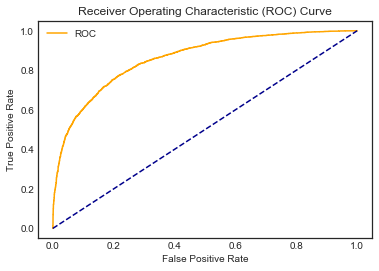

0.8598652586024637

In [13]:
#SVC
y_probs = svc_precision_recall.predict_proba(X_test) # we have to get the probability values to plot roc curve
y_probs = y_probs[:, 1] # keep probabilities for the positive outcome only
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr)
svc_auc = roc_auc_score(y_test, y_probs)
svc_auc

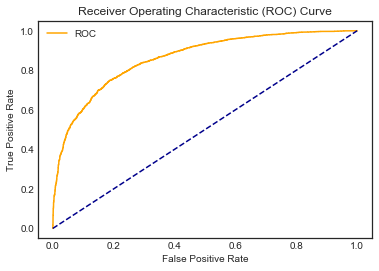

0.8609873671229766

In [14]:
#LR
y_probs = lr_precision_recall.predict_proba(X_test) # we have to get the probability values to plot roc curve
y_probs = y_probs[:, 1] # keep probabilities for the positive outcome only
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr)
lr_auc = roc_auc_score(y_test, y_probs)
lr_auc

In [15]:
print('SVC Confusion Matrix')
confusion_matrix(y_test, pred_svc)

SVC Confusion Matrix


array([[2680,  733],
       [ 791, 2657]], dtype=int64)

In [16]:
print('LR Confusion Matrix')
confusion_matrix(y_test, pred_lr)

LR Confusion Matrix


array([[2635,  778],
       [ 749, 2699]], dtype=int64)

C:\Users\jkom8\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jkom8\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jkom8\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jkom8\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jkom8\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

LR: 0.777784 (0.008024)


C:\Users\jkom8\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jkom8\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jkom8\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jkom8\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

SVM: 0.777909 (0.007753)


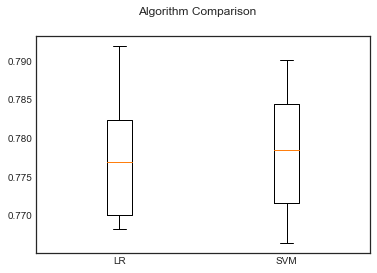

In [17]:
from sklearn import model_selection


# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', lr))
models.append(('SVM', svc))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()